In [1]:
import subprocess
import math
import time
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.lines as mlines
matplotlib.use("Pdf")
print "Using matplotlib version %s" % matplotlib.__version__
import matplotlib.pyplot as plt

from IPython.display import Image, display

def ShowPDF(pdfs, width=None):
    '''Displays images in *pdfs*, which can be one PDF or list of PDFs. Multiple images displayed side-by-side.'''
    png = '_temp.png'
    if not isinstance(pdfs, list):
        pdfs = [pdfs]
    subprocess.check_call(['convert', '-density', '134', ] + pdfs + ['+append', png])
    time.sleep(0.5)
    display(Image(png, width=width))

color1 = '#ab00ab' # purple
color2 = '#52b216' # green
color3 = '#ff7f00' # orange

Using matplotlib version 1.5.1


In [2]:
# various curve-fitting formulas:

def sigmoid(x, x0, k):
    '''from example use of scipy.optimize.curve_fit found at https://gist.github.com/andrewgiessel/5684769'''
    # forces 0% infectivity
    y = 100 / (1 + np.exp(-k*(x-x0)))
    return y

def sigmoid2(x, x0, k, a):
    '''from example use of scipy.optimize.curve_fit found at https://gist.github.com/andrewgiessel/5684769'''
    # additional parameter for bottoming out above or below zero
    y = 100 / (1 + np.exp(-k*(x-x0)))+a
    return y

def expo(x, a, b, c):
    y = a*np.exp(-b*x)-c
    return y

def expo_fixed_top(x, b, c):
    '''fixes max infectivity to 100%'''
    y = 100*np.exp(-b*x)-c
    return y

def expo_fixed_topbottom(x, b):
    '''fixes max infectivity to 100%, min infectivity to 0%'''
    y = 100*np.exp(-b*x)
    return y

# plotting function:
# I left this in the notebook as opposed to an imported module because I find it easier to tweak fine details of the plot 
# (such font sizes, etc) by adding arguments to this function and redefining within the notebook. Otherwise I think the kernel
# needs to be restarted to import a new version of the module, or some other command needs to be used to import a new version 
# of a module without restarting the notebook kernel... 
def PlotNeutralizationCurves(data, x_datalabel, y_datalabels, outfile, 
                             color_cycle=['k','k','k','k','k','k'],
                             style_cycle=['solid','solid','solid','solid','solid','solid'],
                             fit_cycle=[sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid],
                             fmt_cycle = ['o','o','o','o','o','o'],
                             linewidth=2, fit_curve = False, x_lim = None, y_lim = None, figsize=(5,4),
                             verbose=False, x_label_override=False, alpha=1, markersize=9, mew=0,
                             legend_placement_override=False, no_legend=False,
                             legendfontsize=14):
    '''
    *data* is a dataframe of mAb concentrations and resulting fraction infectivity/stdev. 
    The mAb concentrations have column header *x_datalabel*, and the 
    fractional infectivity and stdev of fractional infectivity should have column headers of
    the items of the list *y_datalabels* followed by '_avg' and '_std', respectively.
    '''
        
    f, ax = plt.subplots()
    handles = [] # proxy artists for the legend to show a single legend entry representing the data (marker) and the curve fit (line)
    
    for i,y_datalabel in enumerate(y_datalabels):
        if fit_curve:
            try: 
                popt, pcov = curve_fit(fit_cycle[i], data[x_datalabel], data[y_datalabel + '_avg']*100)
                minlog = math.log10(min(data[x_datalabel]))
                maxlog = math.log10(max(data[x_datalabel]))
                xcurve = np.logspace(minlog, maxlog, num=100)
                ycurve = fit_cycle[i](xcurve, *popt)
                ax.plot(xcurve, ycurve, color=color_cycle[i], linewidth=linewidth, linestyle=style_cycle[i], label=y_datalabel, alpha=alpha)
                
                if verbose:
                    print "\n\ncurve-fitting info for ", y_datalabel
                    print "fit parameters for curve: ", popt
                    if fit_cycle[i] == expo:
                        (a, b, c) = popt
                        ic50 = np.log((50+c)/a)/-b
                        print "expo fit curve was used; here is the IC50 calculated from the fit parameters: ", ic50
                    elif fit_cycle[i] == expo_fixed_top:
                        (b, c) = popt
                        ic50 = np.log((50+c)/100)/-b
                        print "expo fit fixed top curve was used; here is the IC50 calculated from the fit parameters: ", ic50
            except:
                print "Threw an exception during fitting {0} curve for {1}".format(fit_cycle[i], y_datalabel)
                        
        ax.errorbar(data[x_datalabel], data[y_datalabel + '_avg']*100, 
                    yerr=data[y_datalabel + '_std']*100, 
                    color=color_cycle[i], fmt=fmt_cycle[i], 
                    capthick=2, elinewidth=2, markersize=markersize, capsize=markersize/1.5,
                    label=y_datalabel, mew=mew)
        
        custom_handle = mlines.Line2D([], [], color=color_cycle[i], marker=fmt_cycle[i], 
                                      markersize=1.*markersize, linestyle=style_cycle[i], label=y_datalabel,
                                      linewidth=1.*linewidth, mew=mew)
        handles.append(custom_handle)
    
    if x_lim:
        ax.set_xlim(x_lim)
    else:
        ax.set_xlim([4E-3,100])
    ax.set_xscale("log")
    
    if y_lim:
        ax.set_ylim(y_lim)
    else:
        ax.set_ylim([-5,120])
    
    spineOffset = {'left': 8, 'bottom': 8}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ] 
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    ax.xaxis.set(ticks_position = 'bottom')
    ax.yaxis.set(ticks_position = 'left')
    plt.tick_params(axis='both', which='major', labelsize=16, width=2)
    
    if x_label_override:
        plt.xlabel(x_label_override, fontsize=19)
    else:
        plt.xlabel('ug/ml', fontsize=19)

    plt.ylabel('% infectivity', fontsize=19)
    
    if not no_legend:
        if legend_placement_override:
            lgd = ax.legend(handles, y_datalabels, fontsize=legendfontsize, 
                        loc=legend_placement_override, 
                        numpoints = 1, markerscale=1.)
        else:
            lgd = ax.legend(handles, y_datalabels, fontsize=legendfontsize, 
                            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                            numpoints = 1, markerscale=1.)
        f.set_size_inches(figsize)
        plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    else:
        f.set_size_inches(figsize)
        plt.savefig(outfile, bbox_inches='tight')

    plt.close()

In [3]:
mutant_data_fi6v3 = pd.read_csv('20170418_FI6v3_neutralization_data.csv')

## summarize the main findings

I will focus the results on the 4 top mutations by mutdiffsel (K294S, K294T, G390R, and N305S) and include V148T as a mutation that should have no effect.

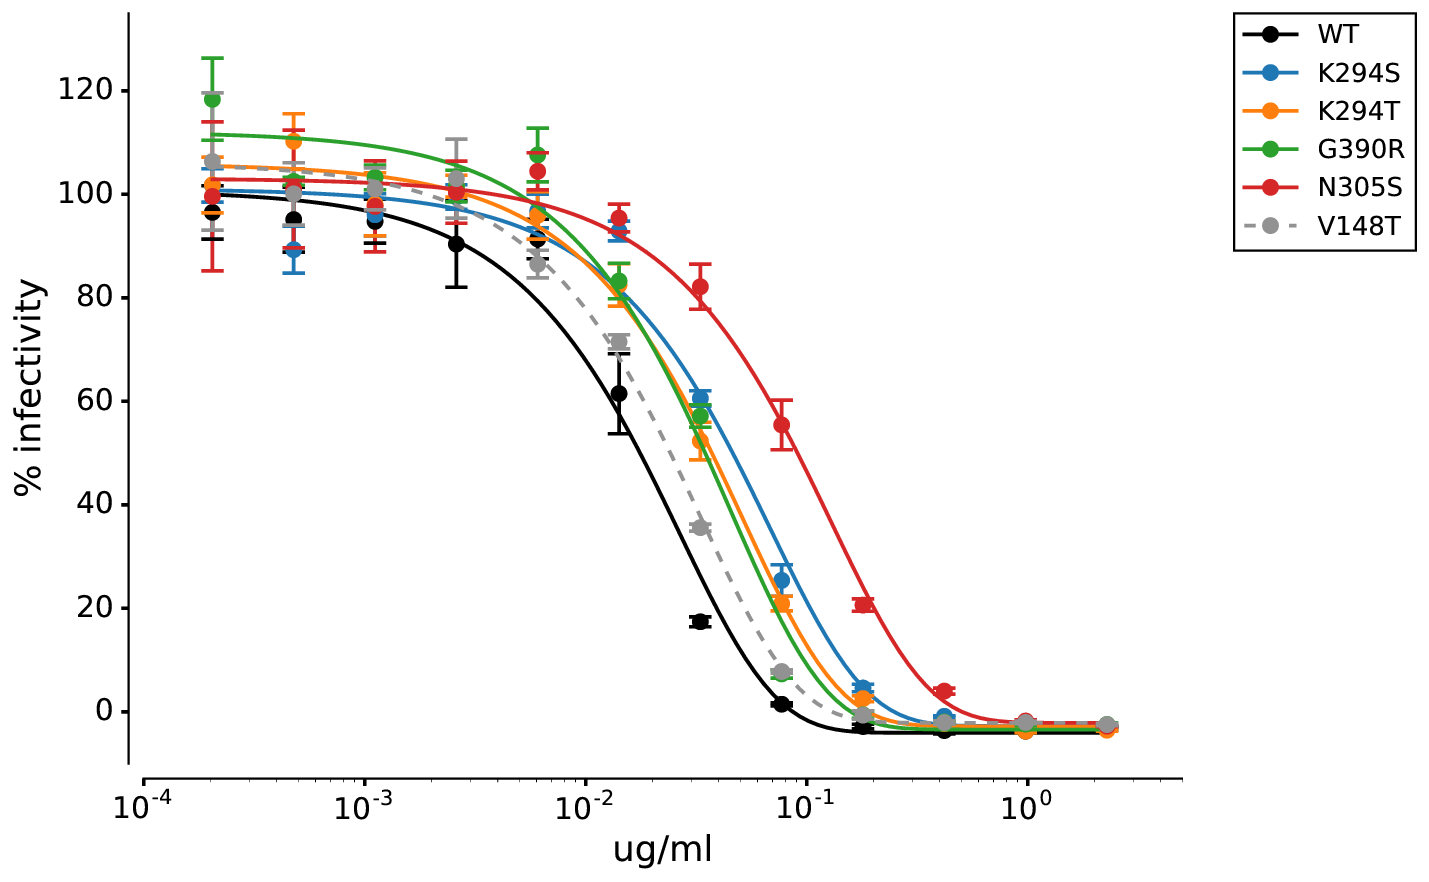

In [5]:
#muts = ['WT', 'K294S', 'K294T', 'G390R', 'N305S', 'M360L', 'K294A', 'K2T', 'P89D', 'V148T']
muts = ['WT', 'K294S', 'K294T', 'G390R', 'N305S', 'V148T']
colorcycle = ['k', '#1f77b4',  '#ff7f0e', 
             '#2ca02c', '#d62728', 'grey',
             '#9467bd',  '#8c564b',
             '#e377c2',  '#7f7f7f', 
             '#bcbd22',  '#17becf', ]
style_cycle = ['solid' for i in range(len(muts)-1)] + ['dashed']
fit_cycle = [expo, expo, expo, expo, expo, expo]
fmt_cycle = ['o' for i in range(len(muts))]
PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                         muts,
                         'temp.pdf', 
                         color_cycle=colorcycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2,
                         fit_curve = True,
                         x_lim =[1E-4,5], y_lim = [-10,135], figsize=(10,7))
ShowPDF('temp.pdf', width=500)

## show each of those curves one at a time to check that the curve is reasonable; Also display the IC50 calculated from the curve



curve-fitting info for  WT
fit parameters for curve:  [ 104.81473475   37.55438192    4.04346969]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0176385713185


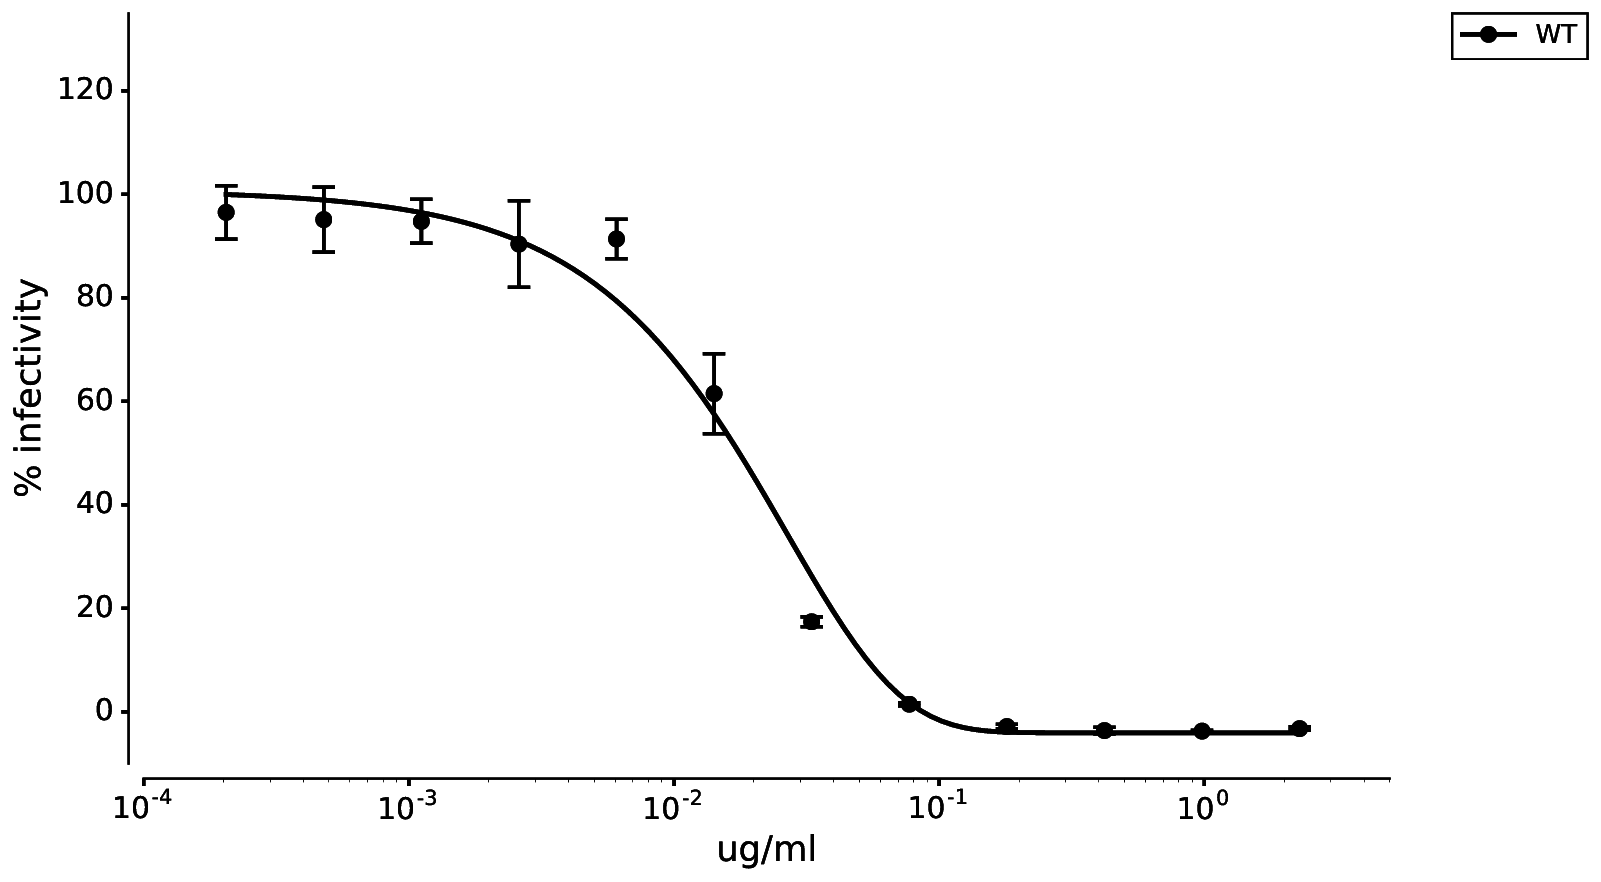



curve-fitting info for  K294S
fit parameters for curve:  [ 103.81187715   14.61479538    2.7387631 ]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0463386343952


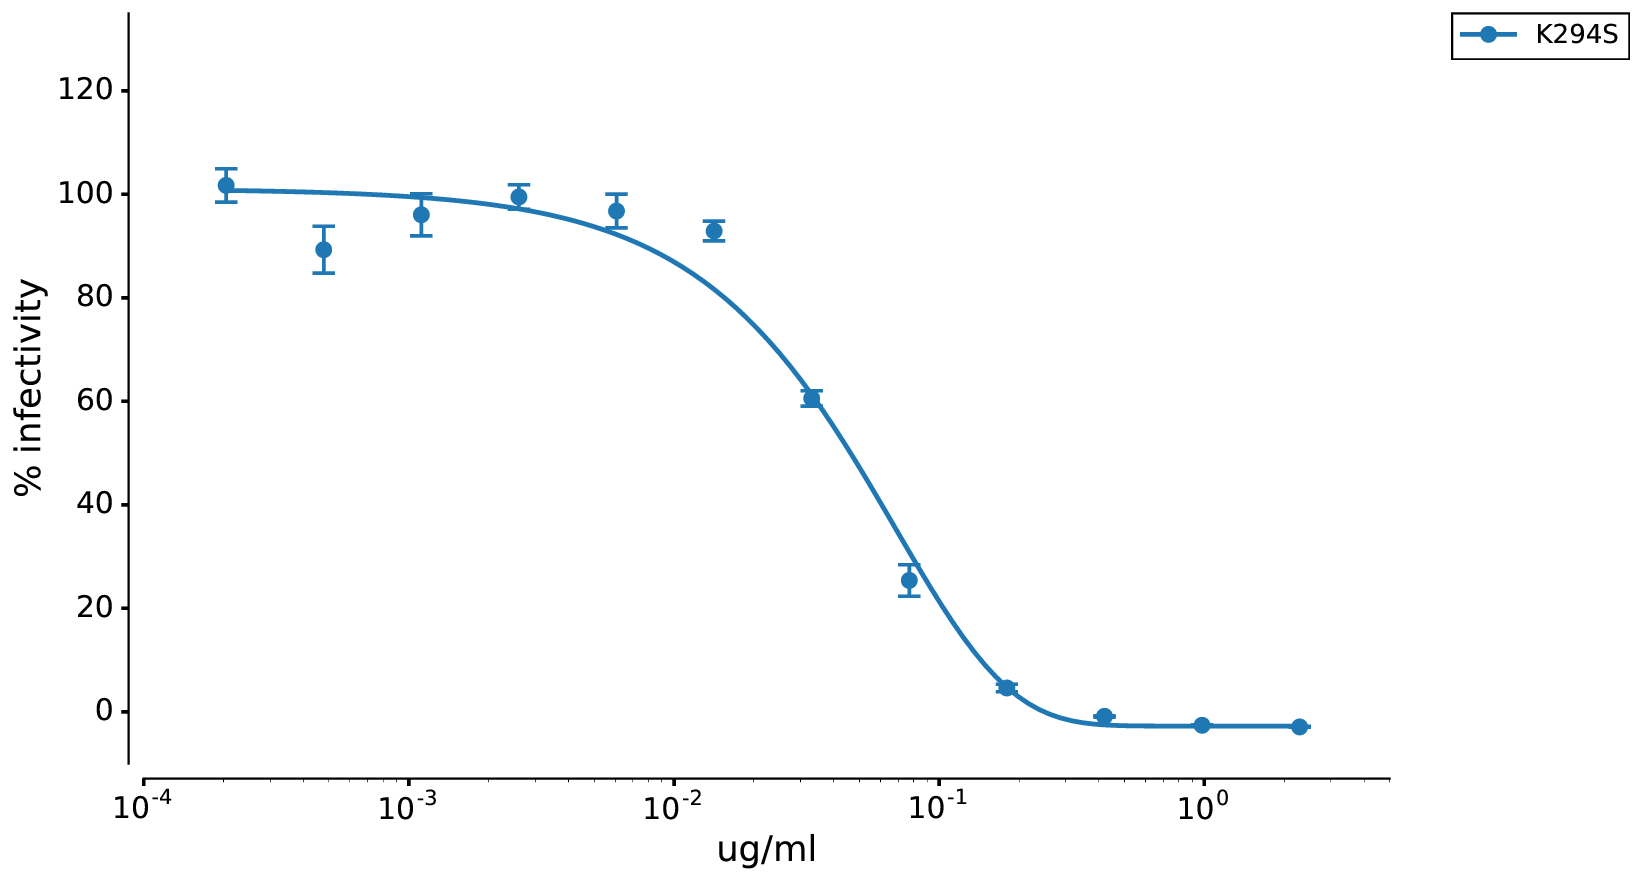



curve-fitting info for  K294T
fit parameters for curve:  [ 108.68536257   19.36889321    2.78678853]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0372863940165


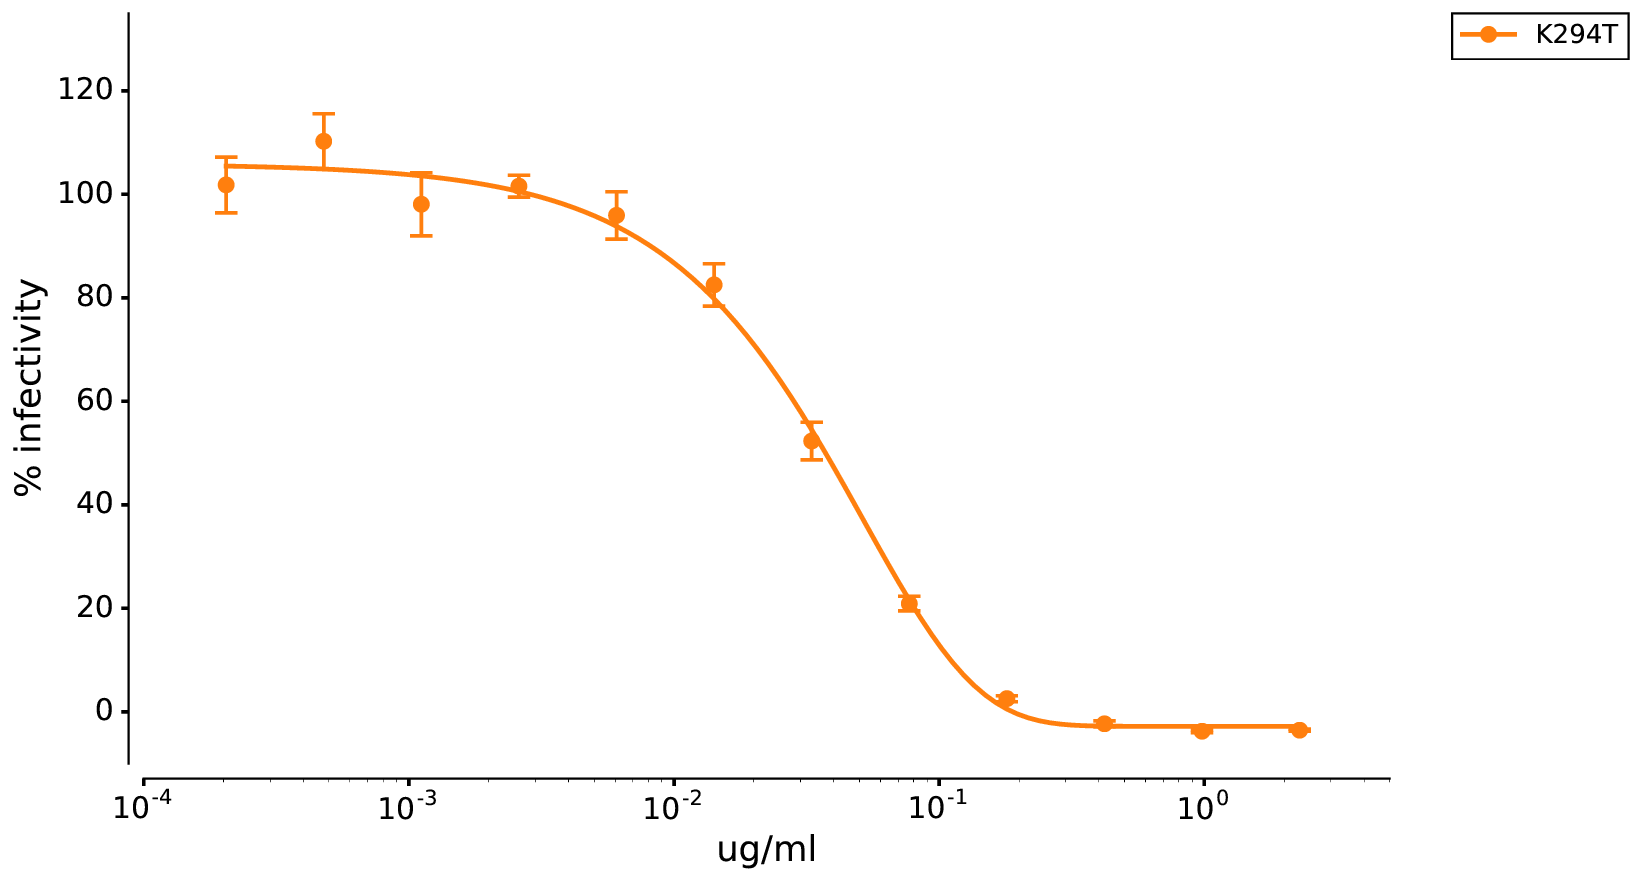



curve-fitting info for  G390R
fit parameters for curve:  [ 115.50065409   22.16925572    3.41479818]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0347863895655


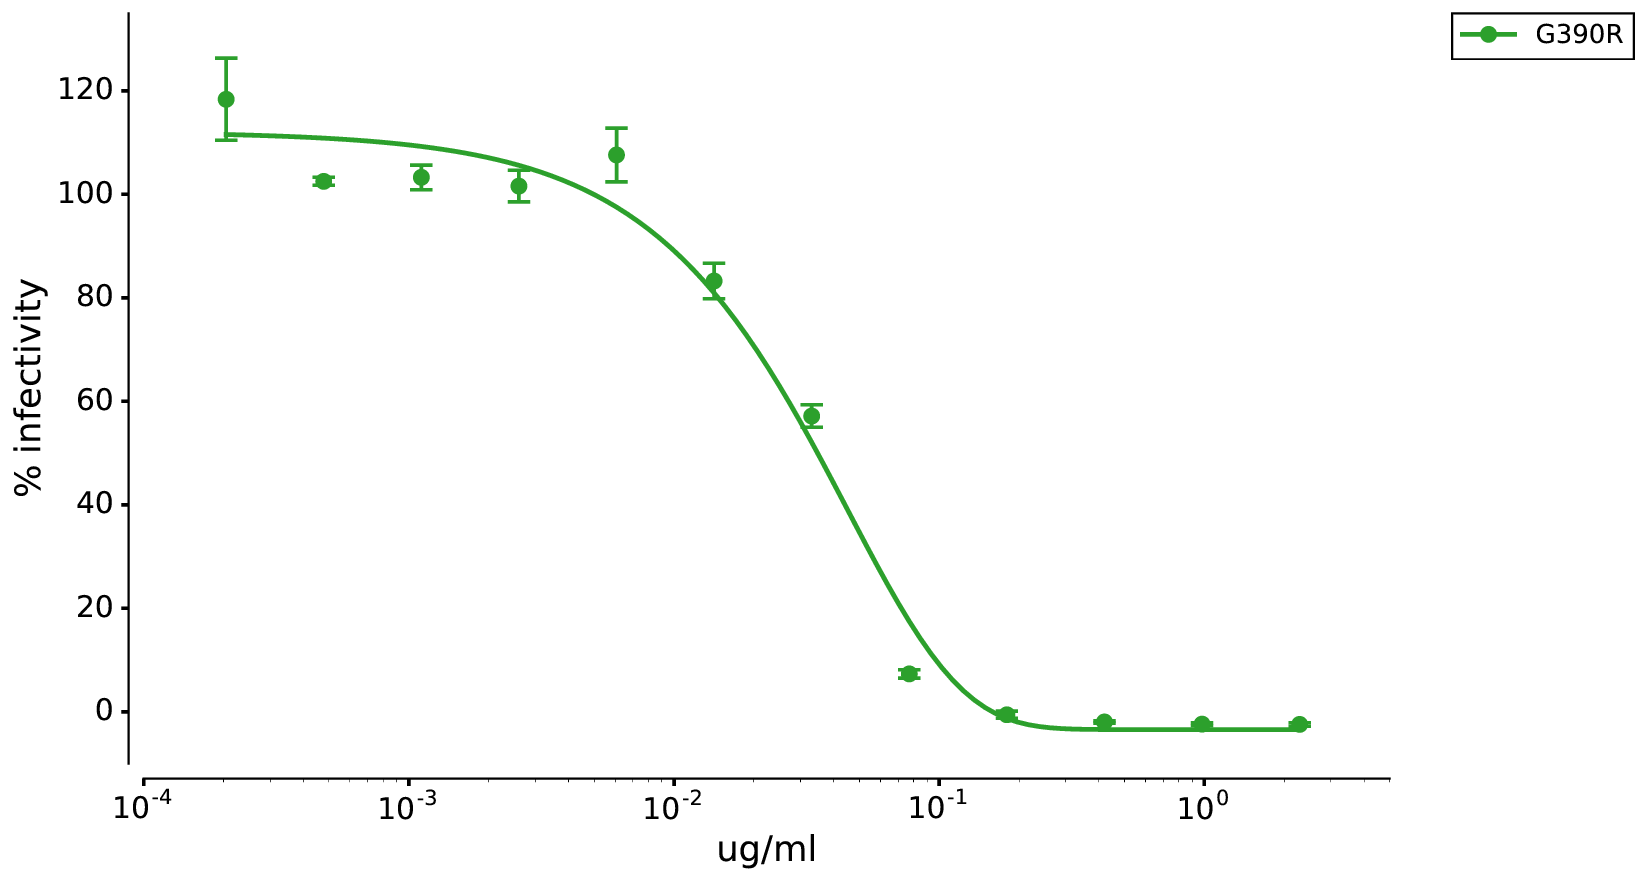



curve-fitting info for  N305S
fit parameters for curve:  [ 105.19535688    7.71947841    2.11932659]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0909754900649


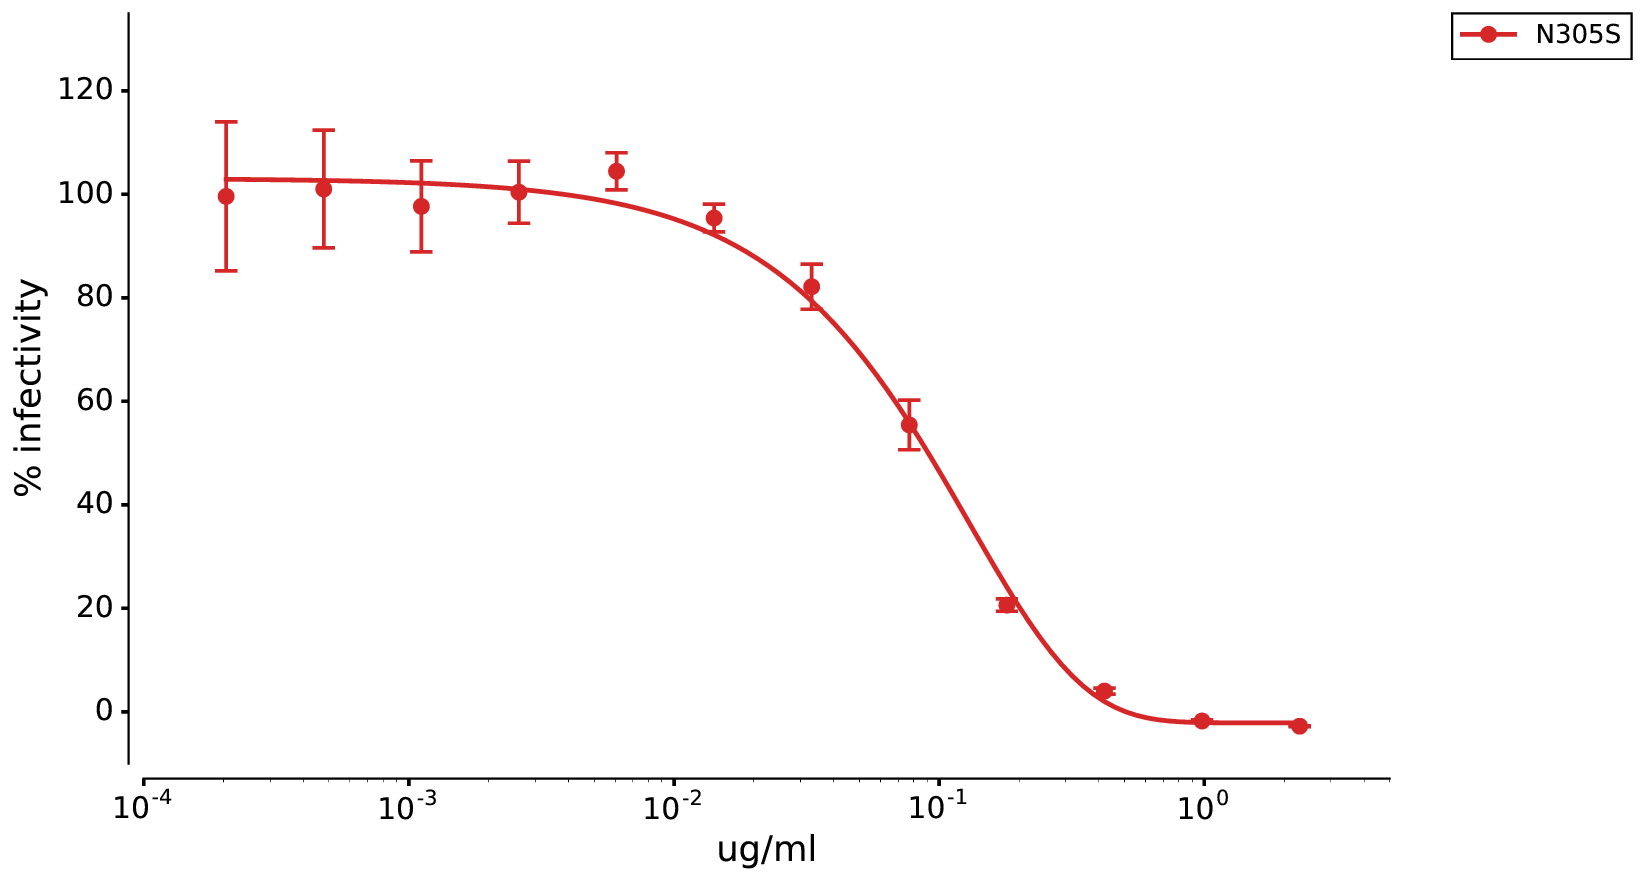



curve-fitting info for  V148T
fit parameters for curve:  [ 108.16484158   30.18462315    2.11080991]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0241939069364


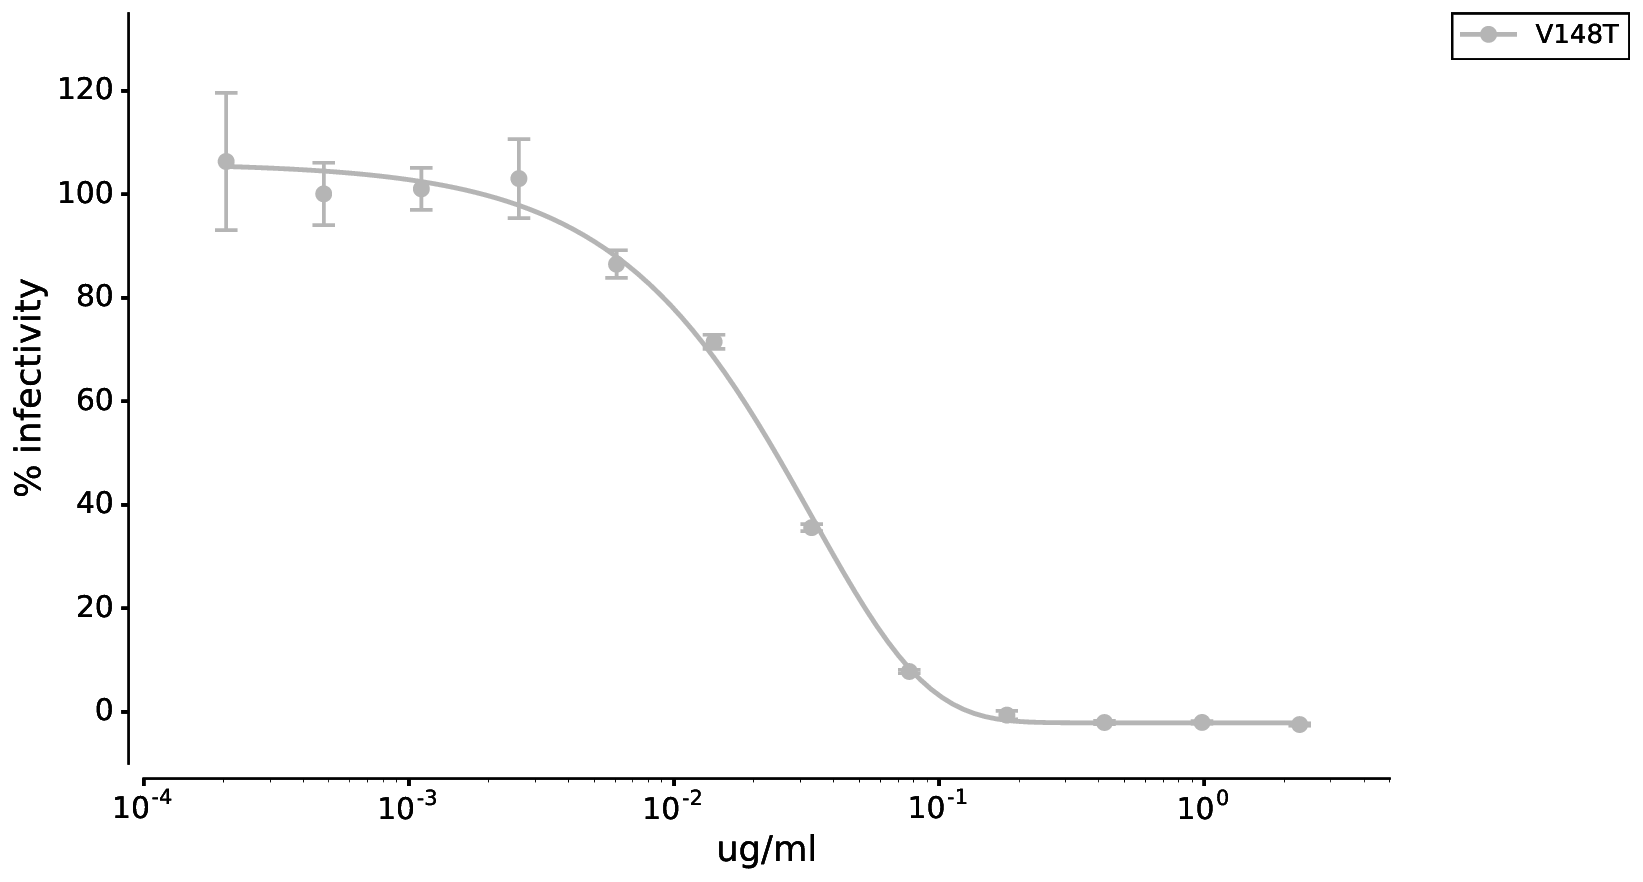

In [6]:
muts = ['WT', 'K294S', 'K294T', 'G390R', 'N305S', 'V148T']
colorcycle = ['k', '#1f77b4',  '#ff7f0e', 
             '#2ca02c', '#d62728', 'lightgrey',
             '#9467bd',  '#8c564b',
             '#e377c2',  '#7f7f7f', 
             '#bcbd22',  '#17becf', ]
style_cycle = ['solid' for i in range(len(muts)-1)] + ['dashed']
fit_cycle = [expo for i in range(len(muts))]
fmt_cycle = ['o' for i in range(len(muts))]

for m, c in zip(muts, colorcycle):
    PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                             [m],
                             'temp.pdf', 
                             color_cycle=[c],
                             style_cycle=['solid'],
                             fit_cycle=[expo],
                             fmt_cycle=['o'],
                             linewidth = 2.5,
                             fit_curve = True,
                             x_lim =[1E-4,5], y_lim = [-10,135], figsize=(12,7), verbose=True)
    ShowPDF('temp.pdf', width=400)

---

# Testing these mutants with H17-L19

In [7]:
mutant_data_h17l19 = pd.read_csv('20170421_H17L19_neutralization_data.csv')

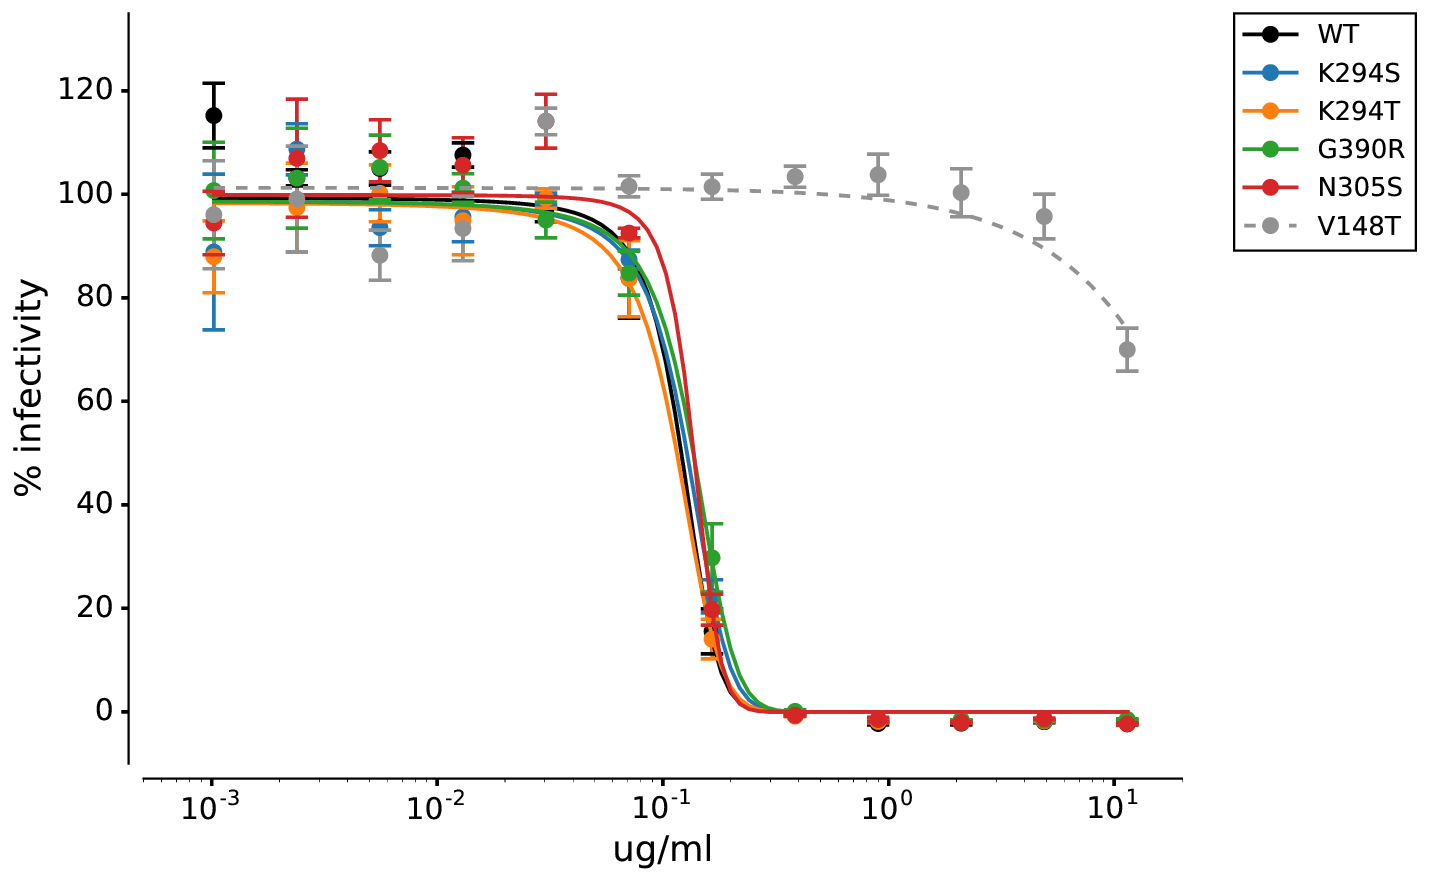

In [8]:
muts = ['WT', 'K294S', 'K294T', 'G390R', 'N305S', 'V148T']
colorcycle = ['k', '#1f77b4',  '#ff7f0e', 
             '#2ca02c', '#d62728', 'grey',
             '#9467bd',  '#8c564b',
             '#e377c2',  '#7f7f7f', 
             '#bcbd22',  '#17becf', ]
style_cycle = ['solid' for i in range(len(muts)-1)] + ['dashed']
#fit_cycle = [expo, expo, expo, expo, expo, expo]
fit_cycle = [sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,expo, expo, expo, expo, expo]


fmt_cycle = ['o' for i in range(len(muts))]
PlotNeutralizationCurves(mutant_data_h17l19, 'ug/ml_H17L19', 
                         muts,
                         '_temp_test.pdf', 
                         color_cycle=colorcycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2,
                         fit_curve = True,
                         x_lim =[5E-4,20], y_lim = [-10,135], figsize=(10,7))
ShowPDF('_temp_test.pdf', width=500)

# possible figures for paper


here is a panel of fi6v3 data without fixing the top of the curve:


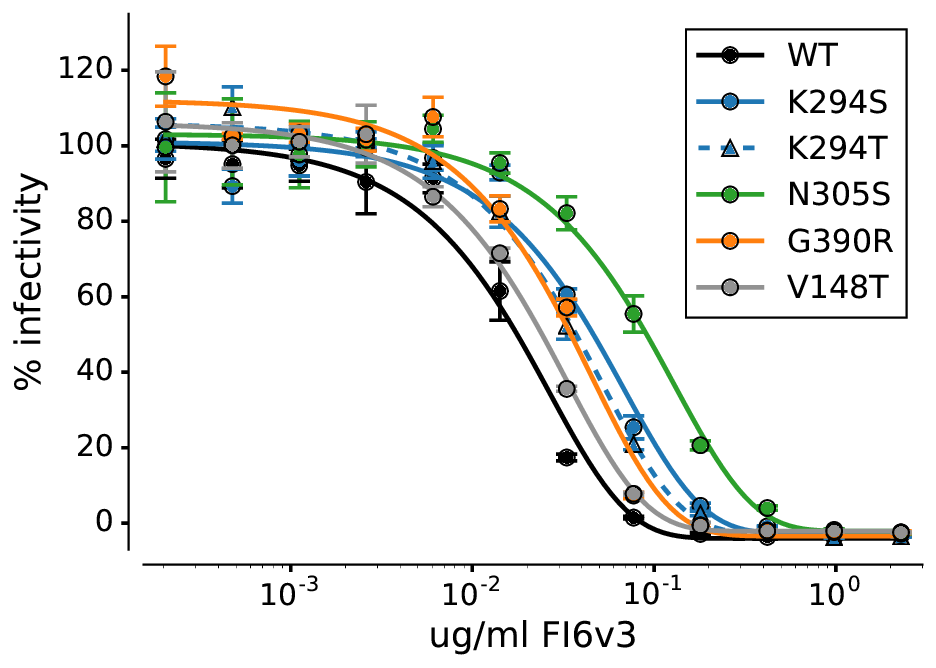

here is a panel of fi6v3 data with the top of the curve fixed to 100%


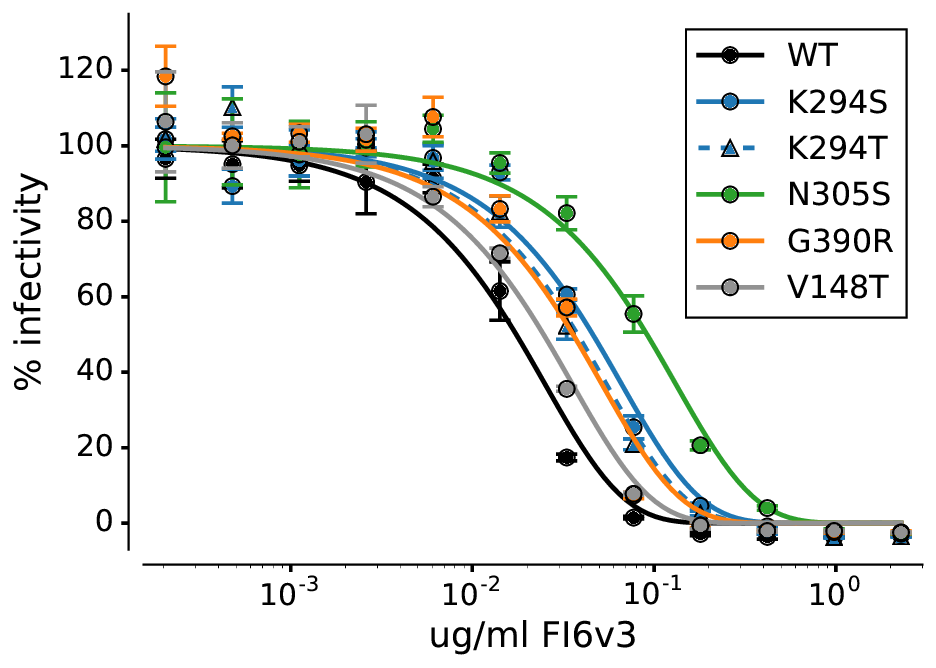

here are the same mutants assayed by H17L19:


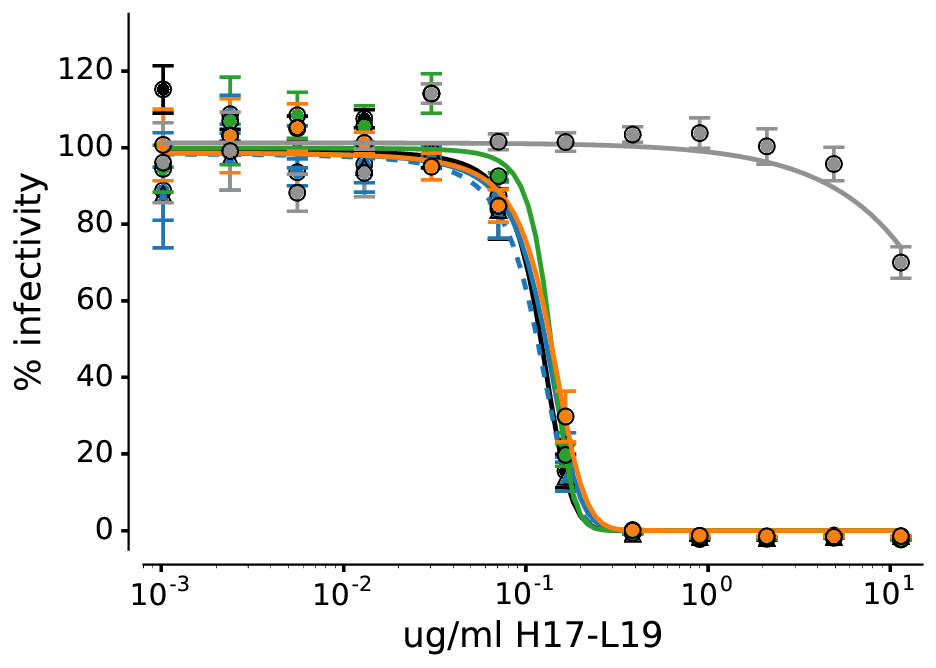

In [12]:
muts = ['WT', 'K294S', 'K294T', 'N305S', 'G390R', 'V148T']
colorcycle = ['k', '#1f77b4','#1f77b4', '#2ca02c', '#ff7f0e', 'grey','#d62728']
style_cycle = ['solid','solid','dashed','solid','solid','solid',]
fmt_cycle = ['o','o','^','o','o','o',]
figsize=(7.5,5)
linewidth=2.5
alpha=1
mew=1
markersize=8.5

# FI6v3 panel:
print "here is a panel of fi6v3 data without fixing the top of the curve:"
fit_cycle = [expo, expo, expo, expo, expo, expo]
PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                         muts, 'FI6v3_neutralization_panel.pdf', 
                         color_cycle=colorcycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = linewidth,
                         fit_curve = True, alpha=alpha, mew=mew, markersize=markersize,
                         x_lim =[1.55E-4,3], y_lim = [-7,135], figsize=figsize,
                         x_label_override='ug/ml FI6v3',
                         legend_placement_override='upper right',
                         legendfontsize=17)
ShowPDF('FI6v3_neutralization_panel.pdf', width=600)

# FI6v3 panel with fixed top of curve:
print "here is a panel of fi6v3 data with the top of the curve fixed to 100%"
fit_cycle = [expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,]
PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                         muts, 'FI6v3_neutralization_panel_fixed.pdf', 
                         color_cycle=colorcycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = linewidth,
                         fit_curve = True, alpha=alpha, mew=mew, markersize=markersize,
                         x_lim =[1.55E-4,3], y_lim = [-7,135], figsize=figsize,
                         x_label_override='ug/ml FI6v3',
                         legend_placement_override='upper right',
                         legendfontsize=17)
ShowPDF('FI6v3_neutralization_panel_fixed.pdf', width=600)

#H17L19 panel:
print "here are the same mutants assayed by H17L19:"
fit_cycle = [sigmoid,sigmoid,sigmoid,sigmoid,sigmoid, expo]
PlotNeutralizationCurves(mutant_data_h17l19, 'ug/ml_H17L19', 
                         muts,
                         'H17L19_neutralization_panel.pdf', 
                         color_cycle=colorcycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = linewidth,
                         fit_curve = True, alpha=alpha, mew=mew, markersize=markersize,
                         x_lim =[8E-4,15], y_lim = [-5,135], figsize=figsize,
                         x_label_override='ug/ml H17-L19',
                         no_legend=True)
ShowPDF('H17L19_neutralization_panel.pdf', width=600)

---

# Might want to spread curves out across multiple panels
for all of these, fixing curve to go from 0% to 100% infectivity in these plots by specifying `expo_fixed_topbottom` in `fit_cycle`

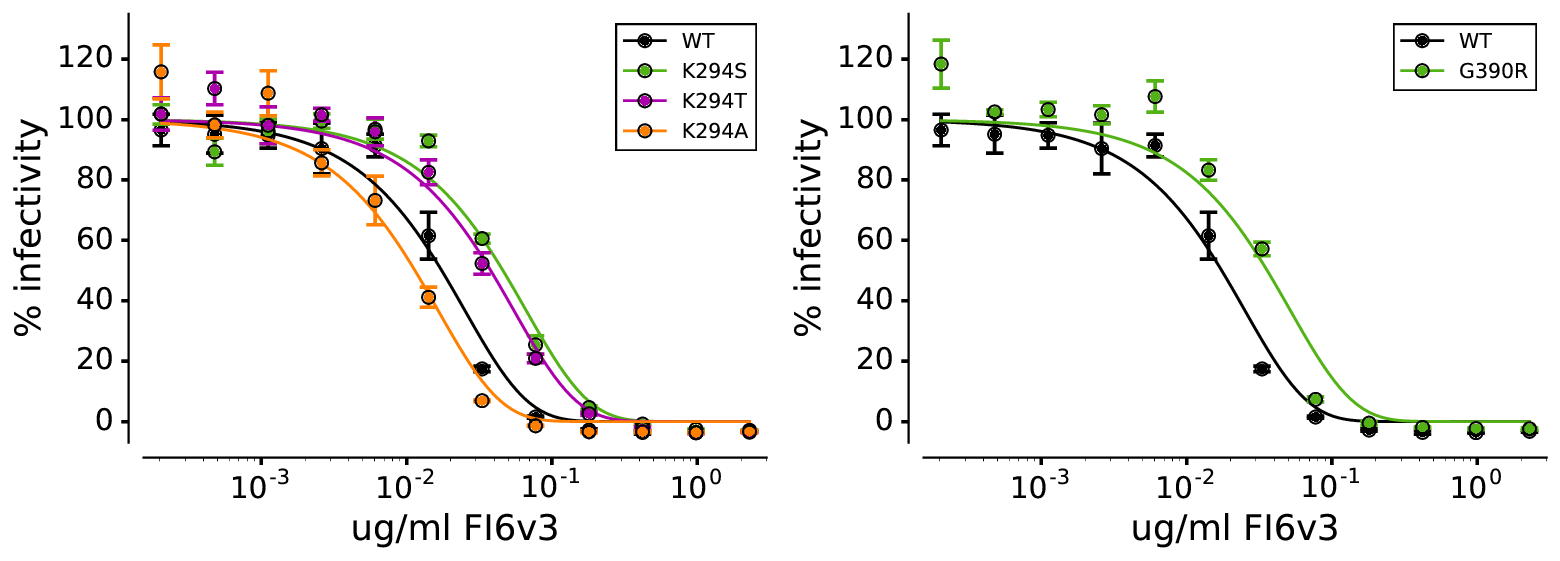

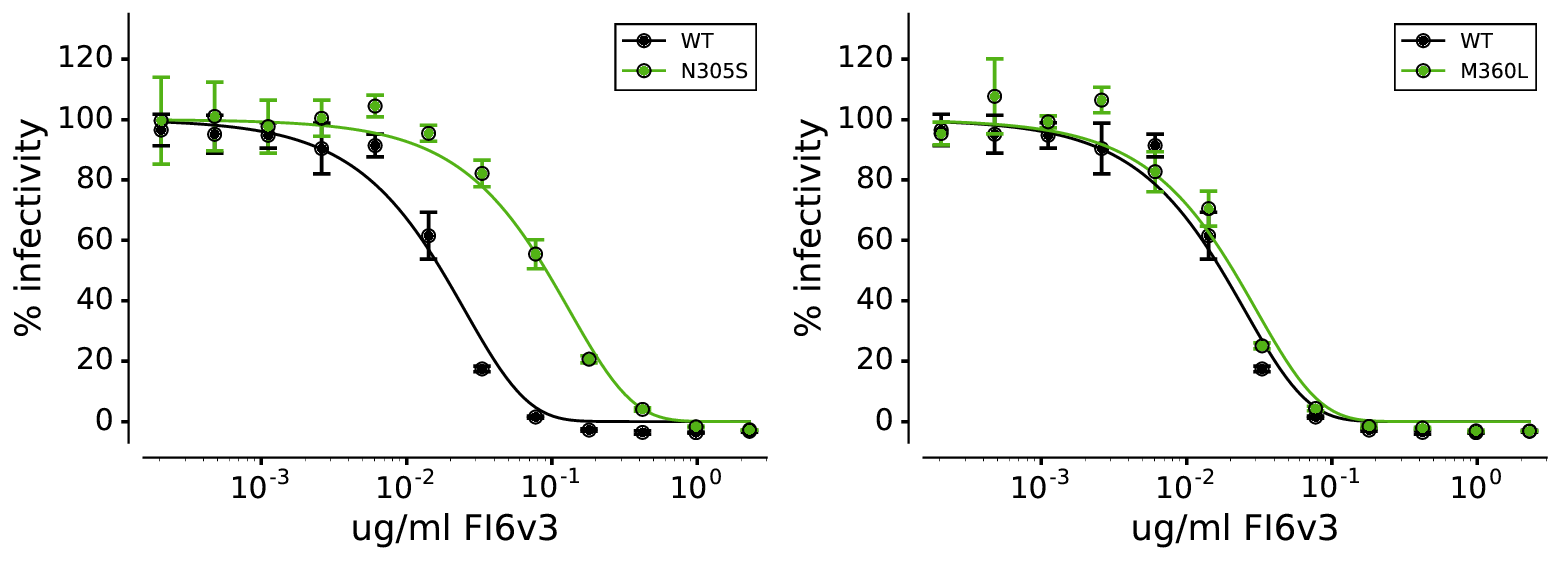

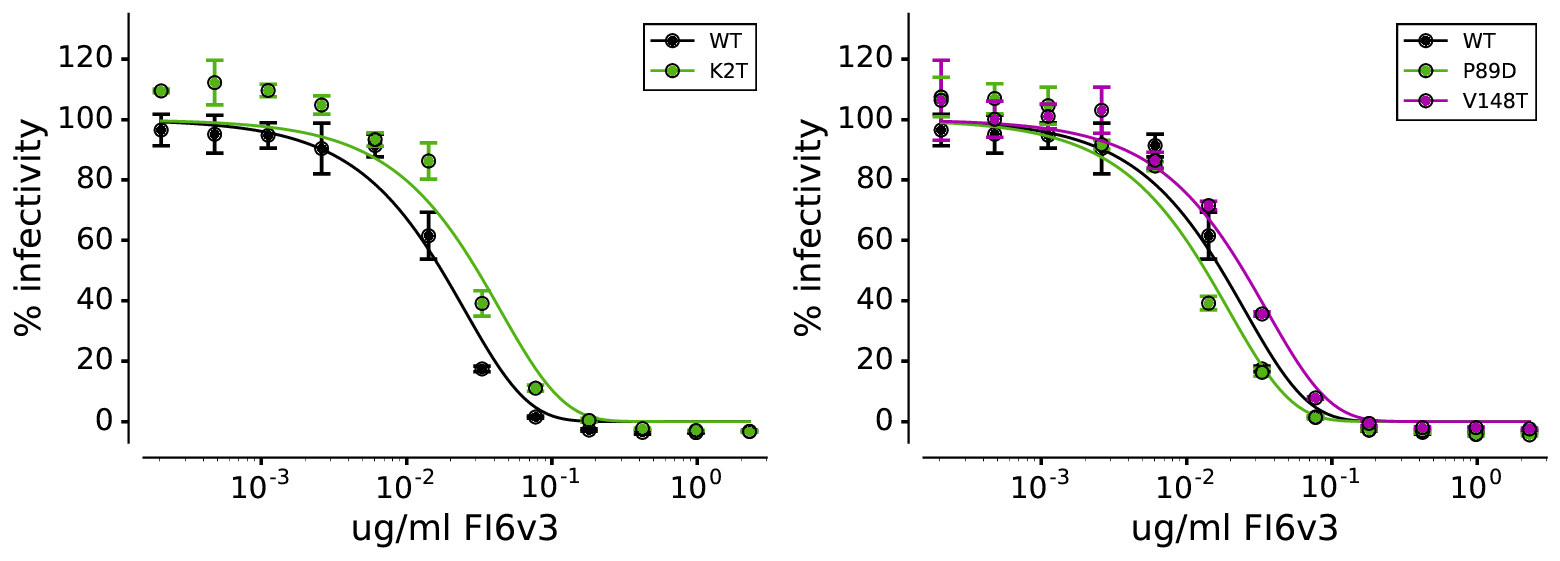

In [11]:
allmuts = ['WT',  'G390R', 'N305S', 'M360L',  'K2T', 'P89D', 'V148T']

mut_sets = [('K294S', 'K294T','K294A'),('G390R',),('N305S',),('M360L',),('K2T',),('P89D','V148T')]

figsize=(6,4)
linewidth=1.5
alpha=1
mew=1
markersize=7

#fit_cycle = [expo, expo, expo, expo, expo, expo, expo, expo]
fit_cycle = [expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom,expo_fixed_topbottom, ]

for i in [0,2,4]:
    these_muts = ['WT']+ list(mut_sets[i])
    PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                             these_muts, 'temp1.pdf', 
                             color_cycle=['k',color2,color1,color3],
                             style_cycle=['solid','solid','solid','solid','solid','solid',],
                             fit_cycle=fit_cycle,
                             fmt_cycle=['o','o','o','o','o','o',],
                             linewidth = linewidth,
                             fit_curve = True, alpha=alpha, mew=mew, markersize=markersize,
                             x_lim =[1.55E-4,3], y_lim = [-7,135], figsize=figsize,
                             x_label_override='ug/ml FI6v3',
                             legend_placement_override='upper right',
                             legendfontsize=11)
    these_muts = ['WT']+ list(mut_sets[i+1])
    PlotNeutralizationCurves(mutant_data_fi6v3, 'ug_ml_FI6v3', 
                             these_muts, 'temp2.pdf', 
                             color_cycle=['k',color2,color1,color3],
                             style_cycle=['solid','solid','solid','solid','solid','solid',],
                             fit_cycle=fit_cycle,
                             fmt_cycle=['o','o','o','o','o','o',],
                             linewidth = linewidth,
                             fit_curve = True, alpha=alpha, mew=mew, markersize=markersize,
                             x_lim =[1.55E-4,3], y_lim = [-7,135], figsize=figsize,
                             x_label_override='ug/ml FI6v3',
                             legend_placement_override='upper right',
                             legendfontsize=11)
    ShowPDF(['temp1.pdf','temp2.pdf'], width=800)